In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from wordcloud import WordCloud
import re
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [89]:
# Load the dataset
file_path = '/workspaces/fdap-2024-gagankhetwani/wg_gesucht_frankfurt_listings.csv'
data = pd.read_csv(file_path)
data_test = pd.read_csv("/workspaces/fdap-2024-gagankhetwani/wg_gesucht_frankfurt_listings.csv")

# Display the first few rows of the dataset
data.head()


,full_link,title,details,price,availability,size,landlord,online_status,description
0,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,3er WG \n |\n\n ...,899 €,15.07.2024,30 m²,Urban Elite,Online: 52 Sekunden,"‼️‼️ Important ‼️‼️IF YOU ARE INTERESTED, PLEA..."
1,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,23 qm Zimmer in WG mit Balkon und Wohnzimmer,5er WG \n |\n\n ...,354 €,01.08.2024,23 m²,Lena,Online: 1 Minute,"Huhu liebe:r zukünftige:r Mitbewohner:in,da un..."
2,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,4er WG \n |\n\n ...,899 €,15.07.2024,30 m²,Urban Elite,Online: 1 Minute,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...
3,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) //...,4er WG \n |\n\n ...,899 €,15.07.2024,15 m²,Urban Elite,Online: 2 Minuten,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...
4,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,Mehr Spaß und Erfolg im Studium?,6er WG \n |\n\n ...,335 €,28.05.2024,15 m²,Julius,Online: 3 Minuten,"Only students, only fluent German.Du bist neu ..."


# Data Cleaning

### Data Processing

In [90]:
# Define a function to extract details using regex
def extract_details(details):
    pattern = re.compile(r'(\d+er WG)\s*\|\s*([^\n]+)\s*([^\|]+)\|\s*([\w\sÃŸ]+)')
    match = pattern.search(details)

    if match:
        return {
            'people_in_wg': match.group(1).strip(),
            'city': match.group(2).strip(),
            'neighborhood': match.group(3).strip(),
            'street': match.group(4).strip()
        }
    else:
        return {
            'people_in_wg': None,
            'city': None,
            'neighborhood': None,
            'street': None
        }

# Apply the function to the 'details' column and create new columns
details_extracted = data['details'].apply(lambda x: extract_details(str(x)))

# Convert the extracted details into a DataFrame and merge with the original DataFrame
details_df = pd.DataFrame(details_extracted.tolist())
data = pd.concat([data, details_df], axis=1)

# Display the first few rows of the updated DataFrame
data.head()

,full_link,title,details,price,availability,size,landlord,online_status,description,people_in_wg,city,neighborhood,street
0,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,3er WG \n |\n\n ...,899 €,15.07.2024,30 m²,Urban Elite,Online: 52 Sekunden,"‼️‼️ Important ‼️‼️IF YOU ARE INTERESTED, PLEA...",3er WG,Frankfurt am Main,Westend-Nord,Oberlindau
1,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,23 qm Zimmer in WG mit Balkon und Wohnzimmer,5er WG \n |\n\n ...,354 €,01.08.2024,23 m²,Lena,Online: 1 Minute,"Huhu liebe:r zukünftige:r Mitbewohner:in,da un...",5er WG,Frankfurt am Main,Bonames,Ben
2,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,4er WG \n |\n\n ...,899 €,15.07.2024,30 m²,Urban Elite,Online: 1 Minute,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...,4er WG,Frankfurt am Main,Nordend-West,Annastraße
3,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) //...,4er WG \n |\n\n ...,899 €,15.07.2024,15 m²,Urban Elite,Online: 2 Minuten,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...,4er WG,Frankfurt am Main,Westend-Süd,Kettenhofweg 83
4,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,Mehr Spaß und Erfolg im Studium?,6er WG \n |\n\n ...,335 €,28.05.2024,15 m²,Julius,Online: 3 Minuten,"Only students, only fluent German.Du bist neu ...",6er WG,Frankfurt am Main,Sachsenhausen,Paul


In [91]:
# Clean the availability column
# Trim the first 10 letters from the availability column
data['availability'] = data['availability'].str[:10]

# Convert the availability column to datetime
data['availability'] = pd.to_datetime(data['availability'], format='%d.%m.%Y')

# Convert 'price' and 'size' to numeric values and clean the data
data['price'] = data['price'].str.replace('€', '').str.replace(' ', '').astype(float)
data['size'] = data['size'].str.replace('m²', '').str.replace(' ', '').astype(float)
data['people_in_wg'] = data['people_in_wg'].str.replace('er WG', '').str.replace(' ', '').astype(int)

# Check for missing values
missing_values = data.isnull().sum()
display(missing_values)

# Display the first few rows and missing values
data.head()


full_link         0
title             0
details           0
price             0
availability      0
size              0
landlord          0
online_status     0
description      17
people_in_wg      0
city              0
neighborhood      0
street            0
dtype: int64

,full_link,title,details,price,availability,size,landlord,online_status,description,people_in_wg,city,neighborhood,street
0,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,3er WG \n |\n\n ...,899.0,2024-07-15,30.0,Urban Elite,Online: 52 Sekunden,"‼️‼️ Important ‼️‼️IF YOU ARE INTERESTED, PLEA...",3,Frankfurt am Main,Westend-Nord,Oberlindau
1,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,23 qm Zimmer in WG mit Balkon und Wohnzimmer,5er WG \n |\n\n ...,354.0,2024-08-01,23.0,Lena,Online: 1 Minute,"Huhu liebe:r zukünftige:r Mitbewohner:in,da un...",5,Frankfurt am Main,Bonames,Ben
2,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,4er WG \n |\n\n ...,899.0,2024-07-15,30.0,Urban Elite,Online: 1 Minute,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...,4,Frankfurt am Main,Nordend-West,Annastraße
3,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) //...,4er WG \n |\n\n ...,899.0,2024-07-15,15.0,Urban Elite,Online: 2 Minuten,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...,4,Frankfurt am Main,Westend-Süd,Kettenhofweg 83
4,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,Mehr Spaß und Erfolg im Studium?,6er WG \n |\n\n ...,335.0,2024-05-28,15.0,Julius,Online: 3 Minuten,"Only students, only fluent German.Du bist neu ...",6,Frankfurt am Main,Sachsenhausen,Paul


In [92]:
# Convert availability column to numeric duration in hours from 14-07-2024 11:31:00
data['availability_hr'] = (data['availability'] - pd.to_datetime('2024-07-14 16:51:00')).dt.total_seconds() / 60

data['availability_hr']

# Convert availability column to numeric duration in days from 14-07-2024 11:31:00
data['availability_days'] = (data['availability'] - pd.to_datetime('2024-07-14 16:51:00')).dt.total_seconds() / (60 * 60 * 24)

data['availability_days']

0       0.297917
1      17.297917
2       0.297917
3       0.297917
4     -47.702083
         ...    
99    -24.702083
100   -58.702083
101   -24.702083
102    21.297917
103     5.297917
Name: availability_days, Length: 104, dtype: float64

### Handling Missing Values

In [93]:
# Handle missing values in the 'size' column
# For simplicity, we'll drop rows where 'size' is missing

data_cleaned = data.dropna(subset=['size'])

# Check if there are any more missing values in 'size'
missing_values_after_cleaning = data_cleaned.isnull().sum()

# Display the number of missing values after cleaning
missing_values_after_cleaning


full_link             0
title                 0
details               0
price                 0
availability          0
size                  0
landlord              0
online_status         0
description          17
people_in_wg          0
city                  0
neighborhood          0
street                0
availability_hr       0
availability_days     0
dtype: int64

# Exploratory Data Analysis (EDA)

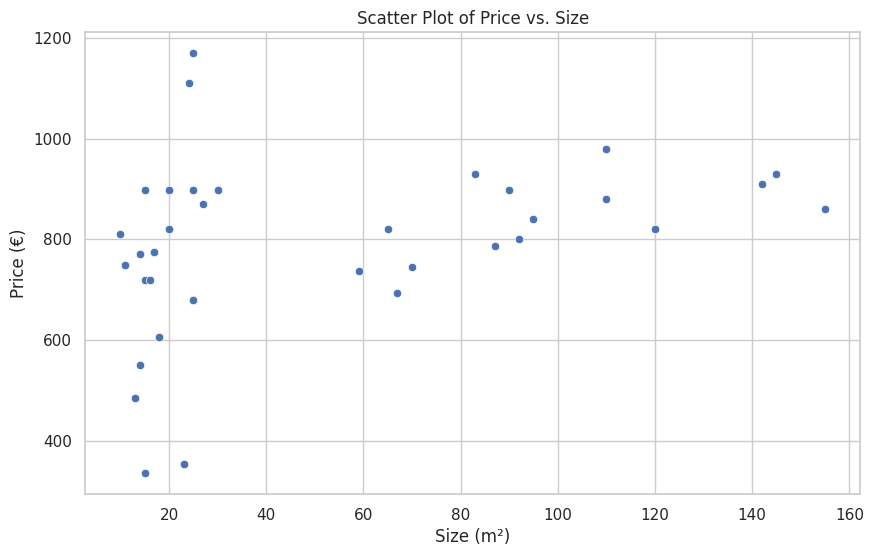

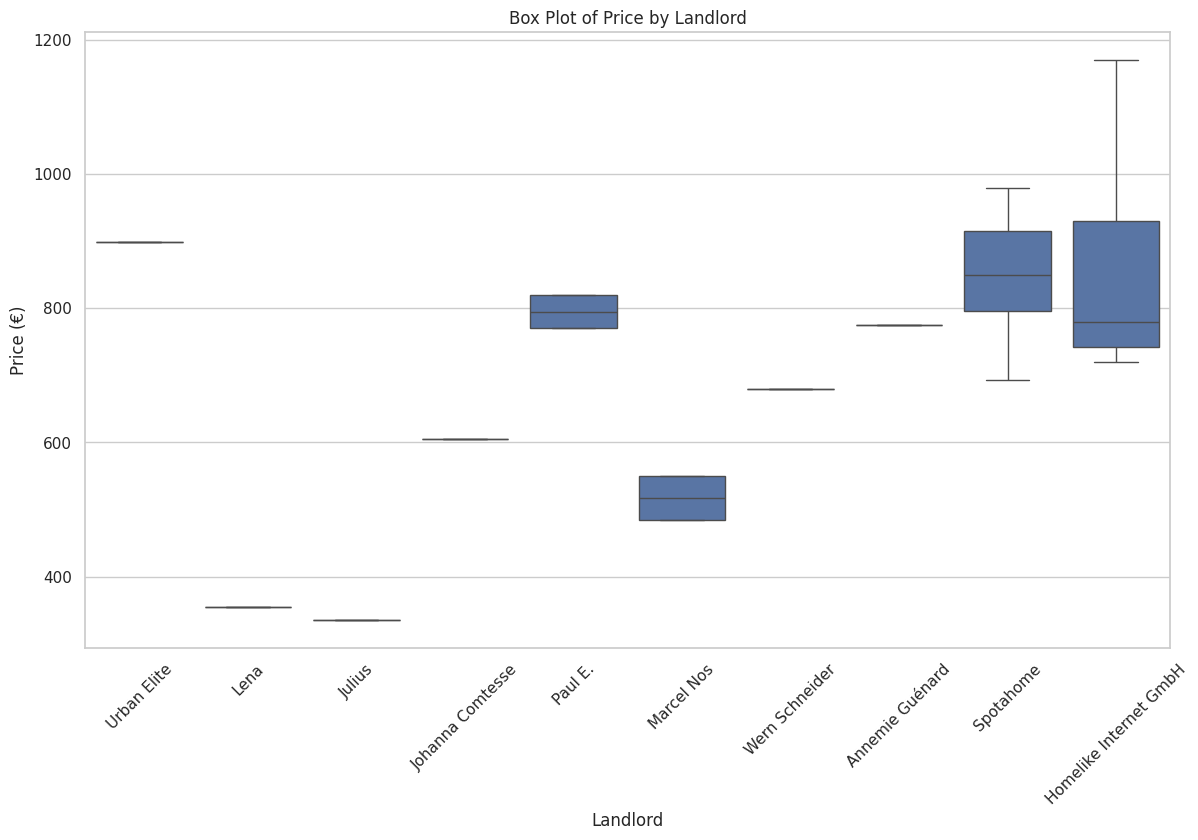

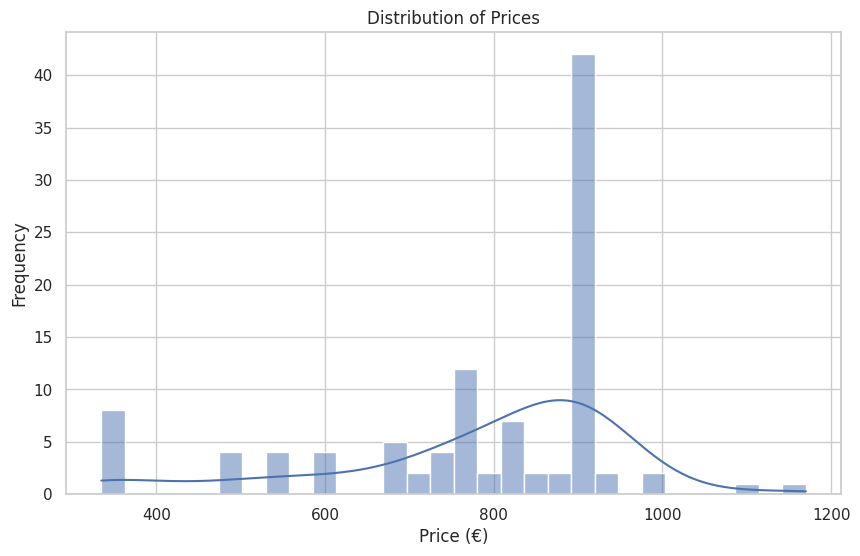

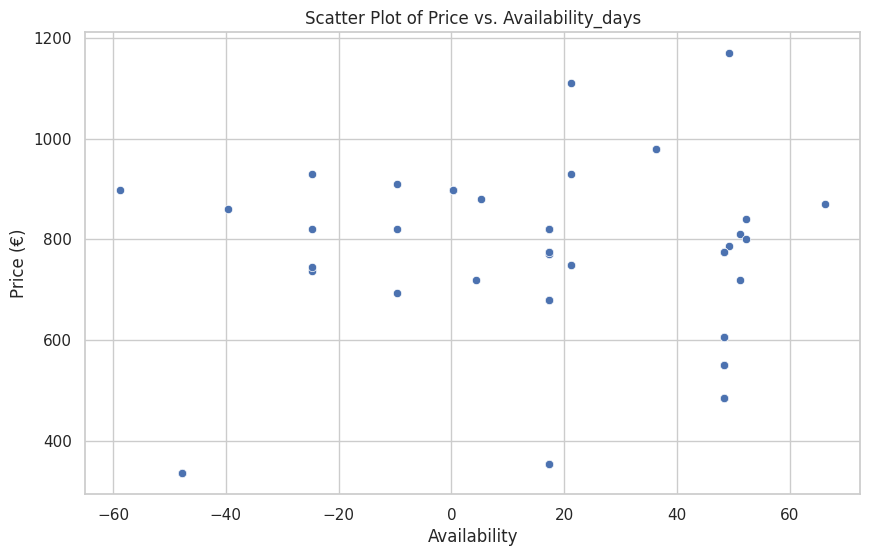

In [94]:
# Set plot style
sns.set(style="whitegrid")

# Scatter plot of Price vs. Size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cleaned, x='size', y='price')
plt.title('Scatter Plot of Price vs. Size')
plt.xlabel('Size (m²)')
plt.ylabel('Price (€)')
plt.show()

# Box plot of Price by Landlord
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_cleaned, x='landlord', y='price')
plt.title('Box Plot of Price by Landlord')
plt.xlabel('Landlord')
plt.ylabel('Price (€)')
plt.xticks(rotation=45)
plt.show()

# Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price (€)')
plt.ylabel('Frequency')
plt.show()


# Scatterplot of Price vs. Availability hours
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cleaned, x='availability_days', y='price')
plt.title('Scatter Plot of Price vs. Availability_days')
plt.xlabel('Availability')
plt.ylabel('Price (€)')
plt.show()

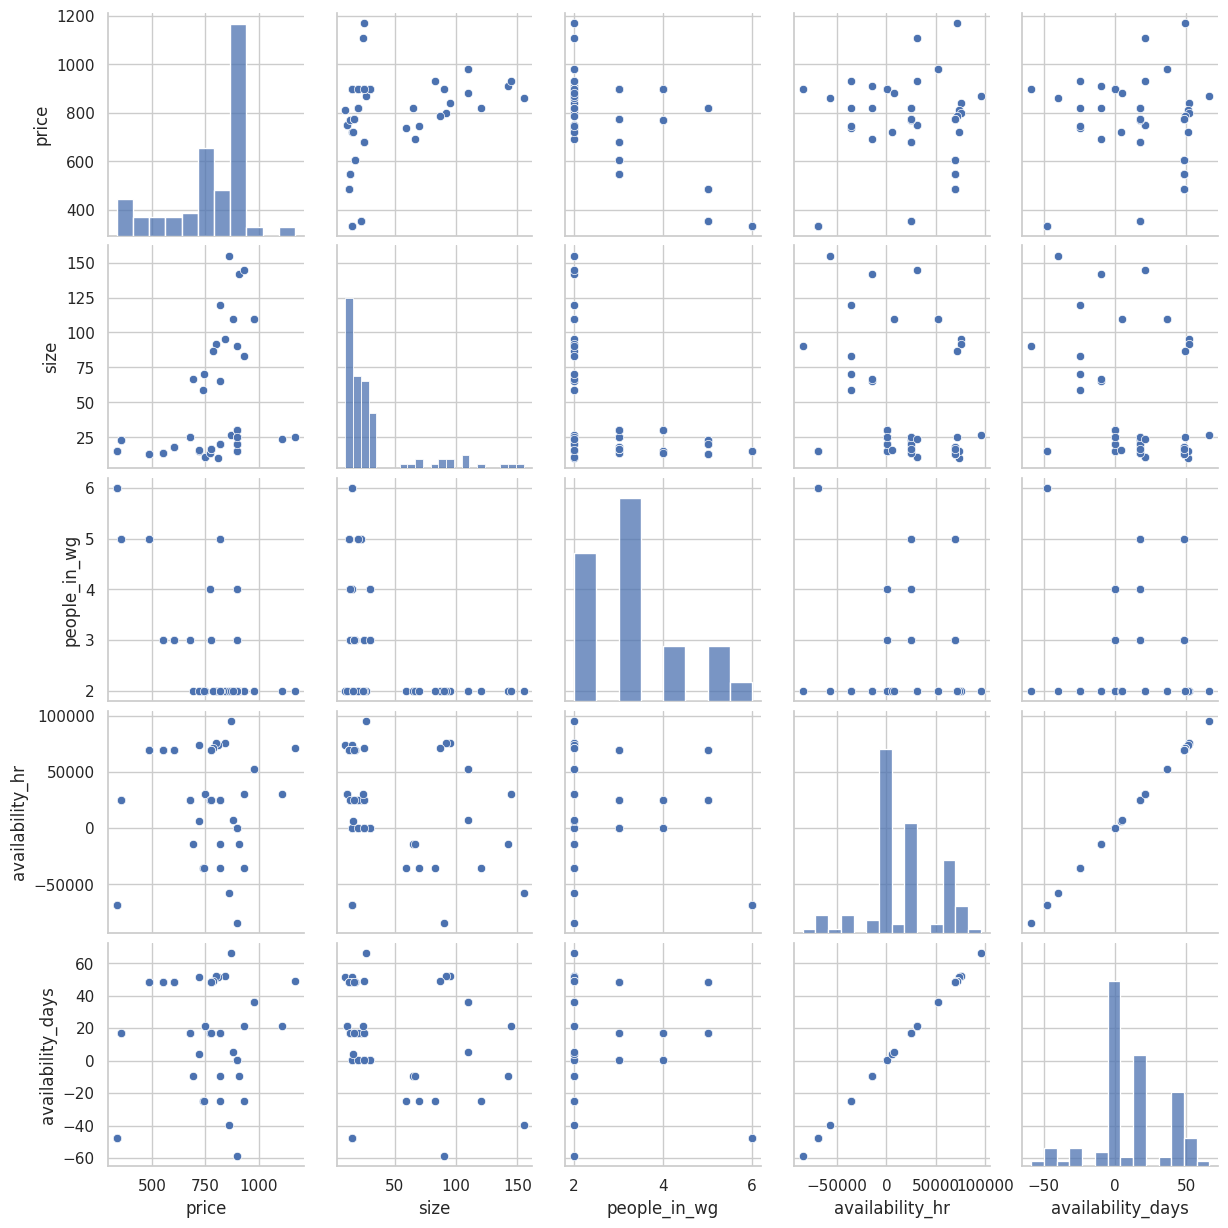

In [95]:
# Pairplot
sns.pairplot(data_cleaned)
plt.show()

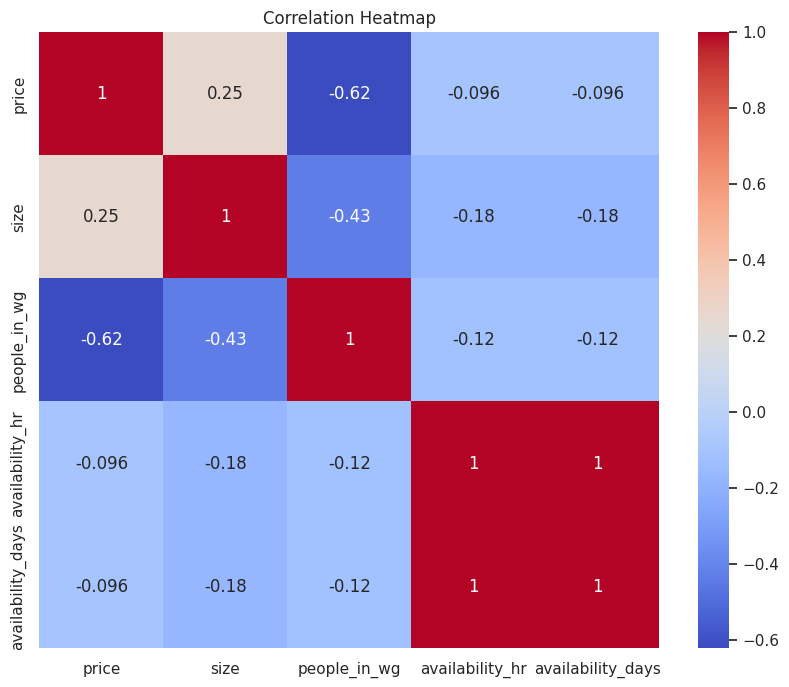

In [96]:
# Choose the numeric columns
numeric_cols = data_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Heatmap for Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(data_cleaned[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Regression Analysis

In [97]:
# Define the independent variables and the dependent variable
X = data_cleaned[['size', 'people_in_wg', "availability_days"]]  # Add other relevant features here
y = data_cleaned['price']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     24.09
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           8.14e-12
Time:                        17:15:48   Log-Likelihood:                -657.99
No. Observations:                 104   AIC:                             1324.
Df Residuals:                     100   BIC:                             1335.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1155.0788     57.05

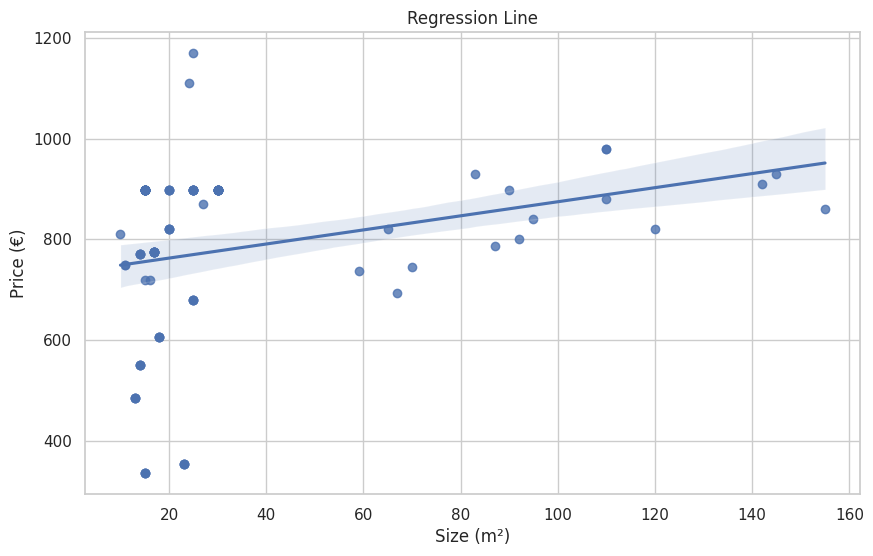

In [98]:
# Plot the regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='size', y='price', data=data_cleaned)
plt.title('Regression Line')
plt.xlabel('Size (m²)')
plt.ylabel('Price (€)')
plt.show()

# Applying Other ML Models

In [99]:
data_cleaned

,full_link,title,details,price,availability,size,landlord,online_status,description,people_in_wg,city,neighborhood,street,availability_hr,availability_days
0,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,3er WG \n |\n\n ...,899.0,2024-07-15,30.0,Urban Elite,Online: 52 Sekunden,"‼️‼️ Important ‼️‼️IF YOU ARE INTERESTED, PLEA...",3,Frankfurt am Main,Westend-Nord,Oberlindau,429.0,0.297917
1,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,23 qm Zimmer in WG mit Balkon und Wohnzimmer,5er WG \n |\n\n ...,354.0,2024-08-01,23.0,Lena,Online: 1 Minute,"Huhu liebe:r zukünftige:r Mitbewohner:in,da un...",5,Frankfurt am Main,Bonames,Ben,24909.0,17.297917
2,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) // ...,4er WG \n |\n\n ...,899.0,2024-07-15,30.0,Urban Elite,Online: 1 Minute,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...,4,Frankfurt am Main,Nordend-West,Annastraße,429.0,0.297917
3,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,URBANELITE.COM // No deposit! (no Kaution) //...,4er WG \n |\n\n ...,899.0,2024-07-15,15.0,Urban Elite,Online: 2 Minuten,-> WWW.URBANELITE.COMWHO WE ARE:We are a start...,4,Frankfurt am Main,Westend-Süd,Kettenhofweg 83,429.0,0.297917
4,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,Mehr Spaß und Erfolg im Studium?,6er WG \n |\n\n ...,335.0,2024-05-28,15.0,Julius,Online: 3 Minuten,"Only students, only fluent German.Du bist neu ...",6,Frankfurt am Main,Sachsenhausen,Paul,-68691.0,-47.702083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,WG in Frankfurt,2er WG \n |\n\n ...,746.0,2024-06-20,70.0,Spotahome,Online: 17.05.2024,NaN,2,Frankfurt am Main,Bahnhofsviertel,Weserstraße Bahnhofsviert,-35571.0,-24.702083
100,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,Zimmer mit Balkon in möblierter 3-Zimmer-Wohnung,2er WG \n |\n\n ...,899.0,2024-05-17,90.0,Spotahome,Online: 17.05.2024,NaN,2,Frankfurt am Main,Altstadt,Töngesgasse 31,-84531.0,-58.702083
101,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,WG in Frankfurt,2er WG \n |\n\n ...,820.0,2024-06-20,120.0,Spotahome,Online: 17.05.2024,NaN,2,Frankfurt am Main,Bornheim,Freiligrathstraße Bornhei,-35571.0,-24.702083
102,https://www.wg-gesucht.de/wg-zimmer-in-Frankfu...,(Verfügbar 1-24 Monate) - Privatwohnung in Ost...,2er WG \n |\n\n ...,1110.0,2024-08-05,24.0,Homelike Internet GmbH,Online: 3 Stunden,NaN,2,Frankfurt am Main,Bornheim,Ostparkstraße 45a,30669.0,21.297917


In [100]:
X = data_cleaned.drop(columns=['price', 'details', 'availability', 'availability_hr', 'title', 'full_link', 'online_status'])
y = data_cleaned.price

In [101]:
# Finding the numerical column names
train_numerical_col = X._get_numeric_data()
num_list = train_numerical_col.columns.to_list()
num_list

['size', 'people_in_wg', 'availability_days']

In [102]:
train_categorical_col = list(set(X.columns) - set(train_numerical_col))
train_categorical_col

['landlord', 'city', 'street', 'neighborhood', 'description']

In [103]:
# Column Transformation to apply feature scaling in all column at once
transformer = ColumnTransformer(transformers = [
    ('tnf1',StandardScaler(),num_list),
    ('tnf2',OneHotEncoder(sparse_output = False, drop = 'first'), train_categorical_col)
], remainder = 'passthrough')

In [105]:
models = {
    "Regression Trees":DecisionTreeRegressor(),
    "Multiple Linear Regression":LinearRegression(),
    "Random Forest":RandomForestRegressor(),
    "Ridge Regression":Ridge(),
    "Lasso Regression":linear_model.Lasso()

    
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train Model
    
    # Make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training Set Performance
    model_train_mean_absolute_error = mean_absolute_error(y_train, y_train_pred)
    model_train_mean_squared_error = mean_squared_error(y_train, y_train_pred, squared = False)
    model_train_r2_score = r2_score(y_train, y_train_pred)
#     model_train_recall = recall_score(y_train, y_train_pred)
#     model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)
    
    # Test Set Performance
    model_test_mean_absolute_error = mean_absolute_error(y_test, y_test_pred)
    model_test_mean_squared_error = mean_squared_error(y_test, y_test_pred, squared = False)
    model_test_r2_score = r2_score(y_test, y_test_pred)
#     model_test_recall = recall_score(y_test, y_test_pred)
#     model_test_rocauc_score = roc_auc_score(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    print('\n')
    
    print('Model performance for Training set')
    print("- MAE: {:.4f}".format(model_train_mean_absolute_error))
    print("- MSE: {:.4f}".format(model_train_mean_squared_error))
    print("- R2 Score: {:.4f}".format(model_train_r2_score))
#     print("- Recall: {:.4f}".format(model_train_recall))
#     print("- Roc Auc Score: {:.4f}".format(model_train_rocauc_score))
    
    print('------------------------------------------------------------------------------------------')
    print('\n')
    
    print('Model performance for Test set')
    print("- MAE: {:.4f}".format(model_test_mean_absolute_error))
    print("- MSE: {:.4f}".format(model_test_mean_squared_error))
    print("- R2 Score: {:.4f}".format(model_test_r2_score))
#     print("- Recall: {:.4f}".format(model_test_recall))
#     print("- Roc Auc Score: {:.4f}".format(model_test_rocauc_score))
    
    print('**'*45)
    print('\n')

NameError: name 'X_train' is not defined

# Word Clouds

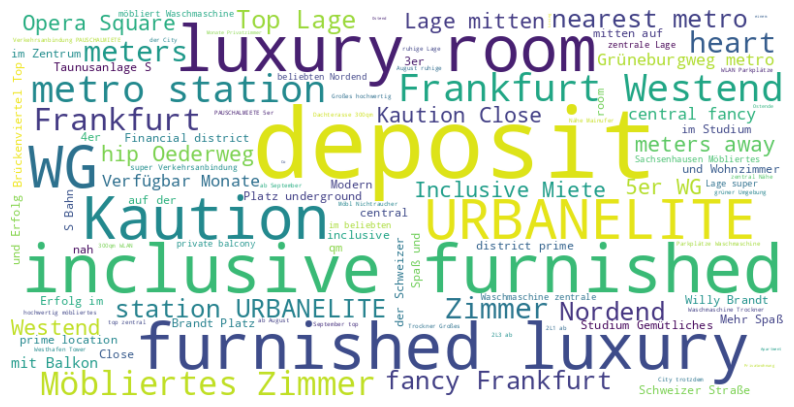

In [106]:
# Word cloud from the titles

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data_cleaned['title']))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

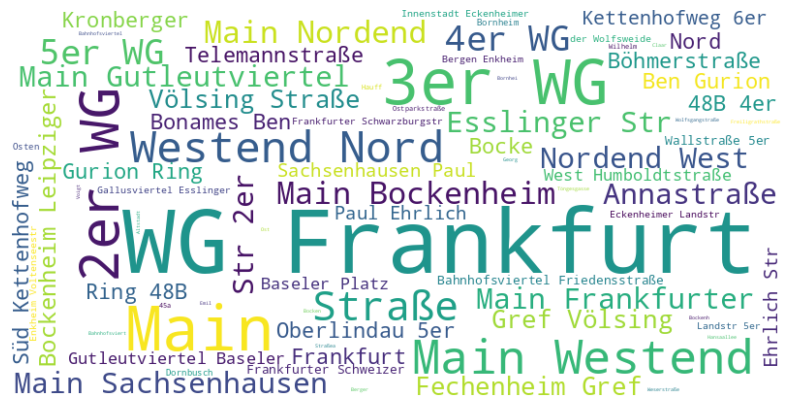

In [107]:
# Wordcloud from the details

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data_cleaned['details']))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

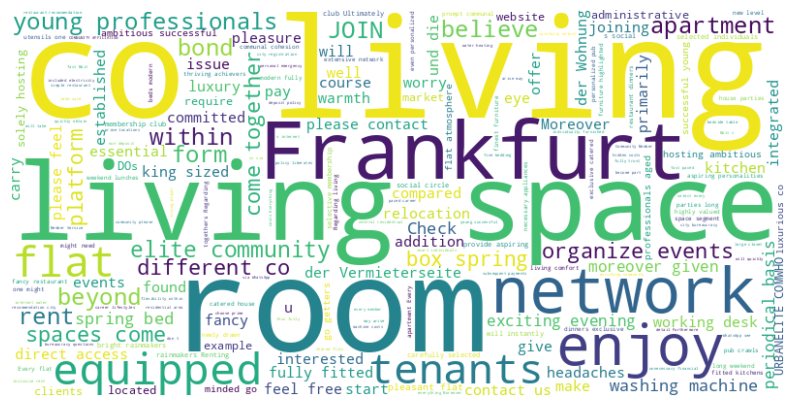

In [108]:
# Wordcloud from the descriptions

# Replace null values in the 'description' column with an empty string
data_cleaned['description'] = data_cleaned['description'].fillna('')

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data_cleaned['description']))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Part 2

<Axes: >

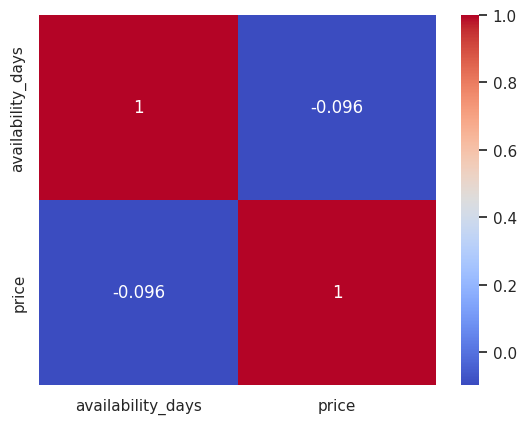

In [109]:
sns.heatmap(data=data_cleaned[['availability_days', 'price']].corr(), cmap='coolwarm', annot=True)